<h1>Creating a Feature Vector</h1>

<h2>Convenient Functions</h2>

In [1]:
import pandas as pd
from geopy.distance import vincenty
import numpy as np

# Define settings
WALKING_RADIUS = 0.25  # Miles a person is expected to walk from a station

# Load station data
df_station = pd.read_csv('./data/station.csv')
df_station = df_station[df_station.city == 'San Francisco']
station_coords = list(zip(list(df_station.lat), list(df_station.long)))
nStations = len(station_coords)

def get_distances(coords):
    ''' Takes a list of lat / long coordinates (as tuple pairs).
        Returns an array of distances (in miles) between all pairs of bike
        stations and coordinates.
        Rows of the array are bike stations, and columns correspond to entries 
        of the supplied coordinates list.'''
    global nStations, station_coords
    nCoords = len(coords)
    distances = np.zeros((nStations, nCoords))
    for idx_station in range(nStations):
        for idx_coord in range(nCoords):
            d = vincenty(coords[idx_coord], station_coords[idx_station]).miles
            distances[idx_station, idx_coord] = d
    return distances

def count_within_walking(coords):
    ''' Takes a list of lat / long coordiantes (as tuple pairs).
        Counts the number of supplied coordinates within a certain radius
        (in miles) of each bike station.
        Returns the count as a NumPy vector, with an entry corresponding to
        each bike station (ordered by row in station.csv) '''
    global WALKING_RADIUS
    distances = get_distances(coords)
    return np.sum(distances <= WALKING_RADIUS, axis = 1)

<h2>Extract Ride Features</h2>

In this section, we create a Pandas DataFrame to store all of the trip features. We then add features from the trip.csv data file, including an indicator for whether the trip occurs on a <b>week day</b>, the <b>hour</b> of day of each trip, and the <b>duration</b> of each trip.

In [2]:
# Load rides data
df_rides = pd.read_csv('data/trip.csv')
date_format = '%m/%d/%Y %H:%M'
trip_starts = pd.to_datetime(df_rides.start_date, format = date_format)
trip_ends = pd.to_datetime(df_rides.end_date, format = date_format)

# Create feature vector, indexed by trip ID
features = pd.DataFrame(index = df_rides.index)

# Feature 1: 1 for week day, 0 for weekend
days_of_week = trip_starts.dt.dayofweek
features['isweekday'] = days_of_week.isin(range(5))

# Feature 2: Trip hour of day (0 to 23)
features['hour'] = trip_starts.dt.hour

# Feature 3: Trip duration (seconds)
features['duration'] = df_rides.duration

# Features 4 / 5: Source / dest station ids
features['source'] = df_rides.start_station_id
features['dest'] = df_rides.end_station_id

# Filter down to rides that start / end in San Francisco
source_in_sf = features.source.isin(df_station.id)
dest_in_sf = features.dest.isin(df_station.id)
features = features[source_in_sf & dest_in_sf]

print(len(features), 'rides loaded!')

603693 rides loaded!


<h2>Elevation</h2>

From [StackOverflow](https://stackoverflow.com/questions/11504444/raster-how-to-get-elevation-at-lat-long-using-python):

In [4]:
import urllib.request
import json
import time

def get_altitude(coord):
    ''' Use the Google Maps API to get elevation (in meters) of each
        lat / long coordinates in a list of coordinates.
    '''
    ELEVATION_BASE_URL = 'http://maps.googleapis.com/maps/api/elevation/json?'
    URL_PARAMS = "locations=%s,%s&sensor=%s" % (coord[0], coord[1], "false")
    url=ELEVATION_BASE_URL + URL_PARAMS
    with urllib.request.urlopen(url) as f:
        time.sleep(0.5)
        response = json.loads(f.read().decode())    
        status = response['status']
        return response["results"][0]['elevation']

# Get Series for elevation of each station
station_elevations = [get_altitude(coord) for coord in station_coords]
elevations = pd.Series(station_elevations, index = df_station.id)

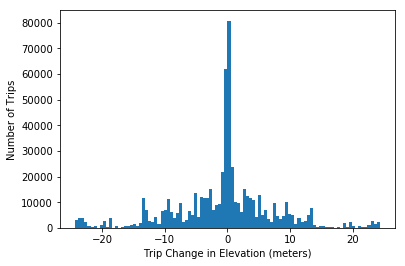

In [5]:
import matplotlib.pyplot as plt

# Calculate change in elevation of each trip
source_elevations = elevations[features.source].values
dest_elevations = elevations[features.dest].values
delta = dest_elevations - source_elevations

# Add change in height feature
features['dheight'] = pd.Series(delta, index = features.index)

# Show distribution
plt.hist(delta, 100)
plt.xlabel('Trip Change in Elevation (meters)')
plt.ylabel('Number of Trips')
plt.show()

<h2>Number of Schools</h2>

Now we start to add contextual data to each ride. Here we count the <b>number of schools</b> within walking distance of each ride's <i>destination</i>.

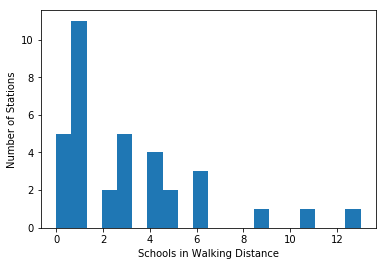

In [6]:
# Load school data and get the coordinates of each school
df_school = pd.read_csv('./data/Schools.csv')
coord_strings = df_school['Location 1'].str.findall('CA\n\((.*),(.*)\)')
school_coords = [(float(s[0][0]), float(s[0][1])) for s in coord_strings]
        
# Create feature for number of schools within walking distance of the destination
school_counts = pd.DataFrame(count_within_walking(school_coords), index = df_station.id)
school_counts.columns = ['schools_at_dest']
features = features.merge(school_counts, left_on = 'dest', right_index = True)

# Show number of schools distribution
plt.hist(school_counts.values, 20)
plt.xlabel('Schools in Walking Distance')
plt.ylabel('Number of Stations')
plt.show()

<h2>Number of BART Stations</h2>

Now we add the <b>number of BART stations</b> (Bay Area Rapid Transit) within walking distance of each ride's destination.

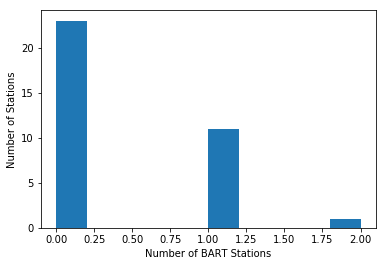

In [7]:
# Load BART station locations
df_bart = pd.read_csv('./data/BART Stations.csv')
bart_coords = list(zip(list(df_bart.gtfs_latitude), list(df_bart.gtfs_longitude)))
        
# Create feature for number of BART stations within walking distance of the destination
bart_counts = pd.DataFrame(count_within_walking(bart_coords), index = df_station.id)
bart_counts.columns = ['bart_at_dest']
features = features.merge(bart_counts, left_on = 'dest', right_index = True)

# Show number of BART stations
plt.hist(bart_counts.values)
plt.xlabel('Number of BART Stations')
plt.ylabel('Number of Stations')
plt.show()

<h2>Number of Tourist Attractions</h2>

Now we add the <b>number of top-20 tourist attractions</b> within walking distance of each ride's destination.

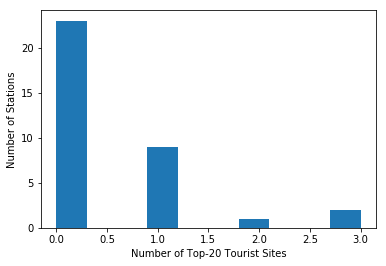

In [8]:
# Load Top 20 attractions
REGEX = '(.*). N, (.*). W'
df_tour = pd.read_csv('./data/Top 20 Attractions.csv')
tour_strings = df_tour['Geographic Coordinates'].str.findall(REGEX)
tour_coords = [(float(s[0][0]), -float(s[0][1])) for s in tour_strings]

# Create feature for number of top-20 tourist attractions within walking distance of the destination
tour_counts = pd.DataFrame(count_within_walking(tour_coords), index = df_station.id)
tour_counts.columns = ['tourism_at_dest']
features = features.merge(tour_counts, left_on = 'dest', right_index = True)

plt.hist(tour_counts.values)
plt.xlabel('Number of Top-20 Tourist Sites')
plt.ylabel('Number of Stations')
plt.show()

<h2>Zoning</h2>

First, we import a GeoJSON file containing polygons for every zone in the city.

In [9]:
import json

with open('./data/Zoning Districts.geojson', 'r') as fid:
    j = json.load(fid)
nZones = len(j['features'])

Now we'll extract information from this JSON file. We are interested in two things. First, we want to know which zones are in walking distance of which bike stations. We'll store this information in a sort of "incidence matrix," a binary array where each row corresponds to a zone and each column to a station. A 1 indicates the corresponding zone-station pair are within walking distance.

We say that a zone is within walking distance of a station if at least one of its polygon vertices is within the WALKING_RADIUS distance of the station.

Second, we want to know general zone type. There are fives types of zones: residential, commercial, industrial, public, and mixed use. We will also store this information in a binary matrix. Again, rows will correspond to zones. But columns will correspond to one of the 5 zone types. A 1 indicates the corresponding zone is of the general type encoded by the corresponding column index.

In [10]:
# Create a map from general zone type to column
gen_types = ['Residential', 'Commercial', 'Industrial', 'Public', 'Mixed Use']
gen_cols = {gen : i for i, gen in enumerate(gen_types)}

# Prepare indicator arrays
walking_indicator = np.zeros((nZones, nStations))
gen_indicator = np.zeros((nZones, len(gen_types)))

for i, feature in enumerate(j['features']):
    
    # Determine which stations are in walking distance
    coords = feature['geometry']['coordinates'][0]
    coords = [(lat, long) for (long, lat) in coords]
    counts = np.array(count_within_walking(coords), dtype = 'int32')
    walking_indicator[i,] = counts >= 1
    
    # Determine general zone type
    zone_gen = feature['properties']['gen']
    gen_indicator[i, gen_cols[zone_gen]] = 1   

Now that the information is extracted, we can examine some general statistics. First, the number of zones of each general type:

In [11]:
for i, gen in enumerate(gen_types):
    print(int(np.sum(gen_indicator[:,i])), '\t', gen, 'zones')

791 	 Residential zones
35 	 Commercial zones
114 	 Industrial zones
316 	 Public zones
336 	 Mixed Use zones


It seems that residential zones dominate, followed by public and mixed use zones, with few industrial zones and even fewer commercial zones. Now we'll examine the distribution of number of zones within walking distance of each zone type:

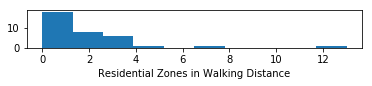

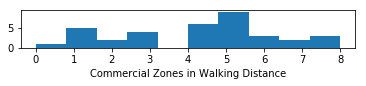

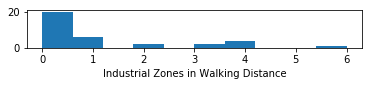

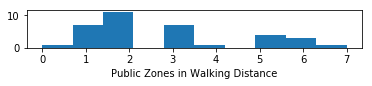

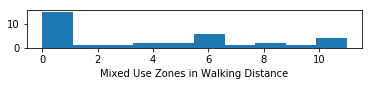

In [12]:
# Matrix multiplication
# Entry i,j is the number of type j zones within walking distance of station i
n_zones = np.dot(walking_indicator.T, gen_indicator)

for i, gen in enumerate(gen_types):
    plt.subplot(5, 1, i + 1)
    plt.hist(n_zones[:,i])
    plt.xlabel(gen + ' Zones in Walking Distance')
    plt.show()

Now we can create features. We will add 5 binary features, one for each general type, indicating whether each station has at least one zone of that type within walking distance.

In [13]:
zone_df = pd.DataFrame(index = df_station.id)
for i, gen in enumerate(gen_types):
    zone_df[gen] = pd.Series(n_zones[:,i] > 0, index = df_station.id)

# Add zone info for source and dest
zone_df.columns = [gen + '_dest' for gen in gen_types]
features = features.merge(zone_df, left_on = 'dest', right_index = True)
zone_df.columns = [gen + '_source' for gen in gen_types]
features = features.merge(zone_df, left_on = 'source', right_index = True)

As a sanity check, let's get some general statistics on these binary features. For each pair of zone types, we will count the number of rides with that zone type near the source, and with that zone type near the destination. We can do this very easily using linear algebra.

In [14]:
# Get source / dest node zone info
dest_zones = features[[gen + '_dest' for gen in gen_types]].as_matrix()
source_zones = features[[gen + '_source' for gen in gen_types]].as_matrix()

# Convert from boolean to integer
dest_zones = np.array(dest_zones, dtype = 'int32')
source_zones = np.array(source_zones, dtype = 'int32')

# Find number of rides with each zone type at source / dest
# Rows are source zone types, cols are dest zone types
source_dest_counts = np.dot(source_zones.T, dest_zones)

# Normalize to a fraction of rides
source_dest_frac = source_dest_counts / len(df_rides)

print(np.round(source_dest_frac, 2))

[[ 0.52  0.67  0.34  0.68  0.61]
 [ 0.66  0.82  0.44  0.85  0.76]
 [ 0.32  0.42  0.21  0.43  0.38]
 [ 0.67  0.84  0.45  0.87  0.78]
 [ 0.6   0.76  0.4   0.78  0.69]]


First, some interesting properties. This matrix is <i>almost</i> symmetric. In fact, we can calculate the percent difference between corresponding entries of the matrix (percent as a fraction of the average between the two entries):

In [15]:
center = (source_dest_counts + source_dest_counts.T) / 2
delta = np.abs(source_dest_counts - source_dest_counts.T)
print(np.round(delta / center, 3))

[[ 0.     0.008  0.069  0.013  0.014]
 [ 0.008  0.     0.063  0.002  0.005]
 [ 0.069  0.063  0.     0.059  0.053]
 [ 0.013  0.002  0.059  0.     0.002]
 [ 0.014  0.005  0.053  0.002  0.   ]]


There is, at most, a 7% difference in counts.

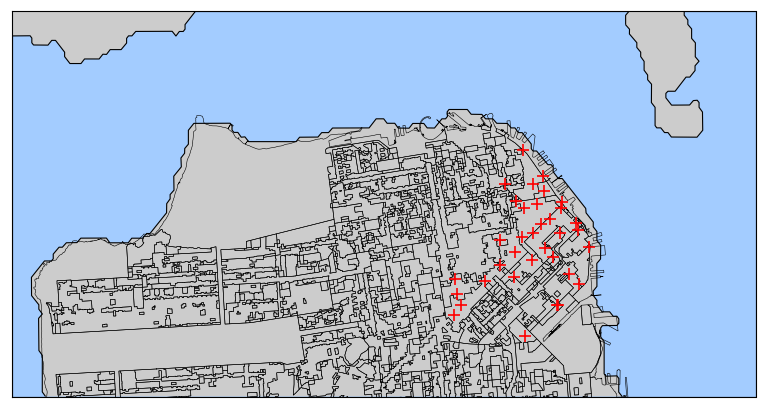

In [17]:
from mpl_toolkits.basemap import Basemap

LOWER_CORNER = (37.76, -122.52)
UPPER_CORNER = (37.83, -122.35)
ORIGIN = (37.779250, -122.419305) # Location of SF city hall

map = Basemap(
    llcrnrlon = LOWER_CORNER[1],
    llcrnrlat = LOWER_CORNER[0],
    urcrnrlon = UPPER_CORNER[1],
    urcrnrlat = UPPER_CORNER[0],
    projection = 'tmerc', 
    resolution = 'f',
    lat_0 = ORIGIN[0], lon_0 = ORIGIN[1])

plt.clf()
fig = plt.figure(figsize=(12, 8), dpi=80)

map.drawmapboundary(fill_color = '#A3CCFF')
map.fillcontinents(lake_color = '#A3CCFF')
map.drawcoastlines()

file = './data/zoning/geo_export_9b2ff14a-9707-4815-b62d-473c20e22332'
map.readshapefile(file, 'zoning')
map.scatter(df_station.long.values, df_station.lat.values, latlon = True, marker = '+', c = 'r', s = 100, zorder = 10)

plt.show()

<h1>Clustering</h1>

<h2>Gaussian Mixture Model</h2>

<h3>Clustering on Zones Alone</h3>

In [21]:
from sklearn import mixture

# Generate 4 clusters based on source / dest zones alone
n_clusters = 5
gmm_features = [gen + '_source' for gen in gen_types]
gmm_features = gmm_features + [gen + '_dest' for gen in gen_types]

# Perform clustering
model = mixture.GaussianMixture(n_clusters).fit(features[gmm_features])

Now that zones are clustered, we can visualize the clusters. The following plots show a 5 x 5 grid of cells. Each row and column corresponds to a zone type. The cell coloring indicates the (approximate) probability of rides within the cluster starting within walking distance of the row zone type and ending within walking distance of the column zone type.

A heatmap color scheme is used, so "hotter" colors like yellow and white indicate higher probabilities than "cooler" colors like red and brown.

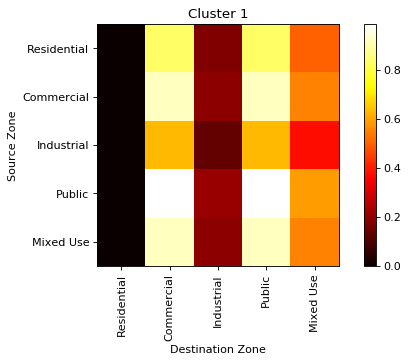

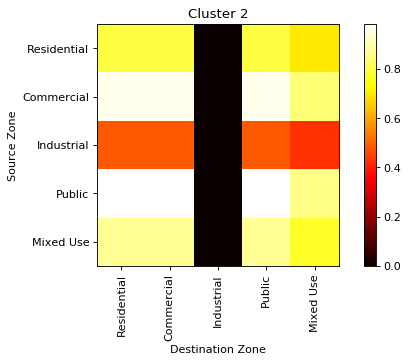

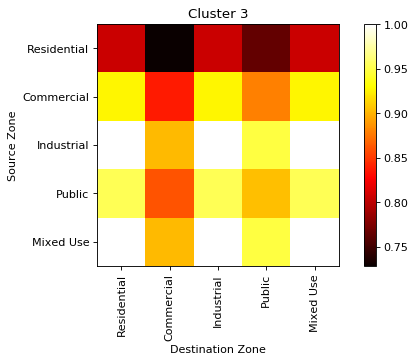

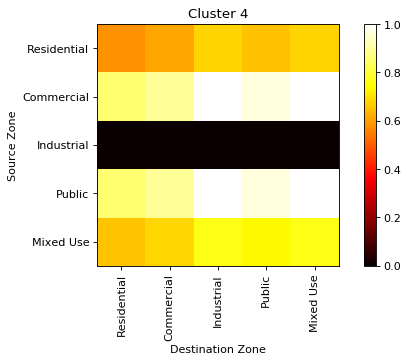

In [20]:
source_means = model.means_[:,:5]
dest_means = model.means_[:,5:]

for k in range(n_clusters):
    
    x = np.outer(source_means[k, :], dest_means[k, :])
    fig = plt.figure(figsize=(8, 4), dpi=80)
    plt.imshow(x, interpolation = 'nearest', cmap = 'hot')
    plt.xticks(range(len(gen_types)), gen_types, rotation = 'vertical')
    plt.xlabel('Destination Zone')
    plt.ylabel('Source Zone')
    plt.yticks(range(len(gen_types)), gen_types)
    plt.title('Cluster ' + str(k + 1))
    plt.colorbar()
    
    plt.show()

<h1>Clustering</h1>

<h2>Gaussian Mixture Model</h2>

First, we'll try the simplest clustering method: using a Guassian Mixture Model (GMM). GMM doesn't work well with nominal data, like whether the trip occurred on a weekend or what the source / destination nodes are, so we will leave these features out of the clustering.

In [67]:
from sklearn import mixture

n_clusters = 4
gmm_features = ['hour', 'duration', 'schools_at_dest', 'bart_at_dest', 'tourism_at_dest', 'dheight']
gmm_features = []
gmm_features = gmm_features + gen_types

# Create separate model for weekday and weekend traffic
weekday_features = features[features.isweekday.values][gmm_features]
weekend_features = features[~features.isweekday.values][gmm_features]

model = dict()
model['weekday'] = mixture.GaussianMixture(n_clusters).fit(weekday_features)
model['weekend'] = mixture.GaussianMixture(n_clusters).fit(weekend_features)

Now we will examine the learned clusters. First the weekday model:

In [68]:
mu = model['weekday'].means_
# print('Cluster hours:\t\t', np.round(mu[:,0], 2))
# print('Cluster durations:\t', np.round(mu[:,1], 2))
# print('Schools at dest:\t', np.round(mu[:,2], 2))
# print('BART at dest:\t\t', np.round(mu[:,3], 2))
# print('Tourism at dest:\t', np.round(mu[:,4], 2))
# print('Ride Height Change:\t', np.round(mu[:, 5], 2))
for i, gen in enumerate(gen_types):
    print(gen, 'Zone Walk:\t', np.round(mu[:, i], 2))

Residential Zone Walk:	 [ 1.  1.  0.  0.]
Commercial Zone Walk:	 [ 1.    0.89  1.    1.  ]
Industrial Zone Walk:	 [ 0.  1.  0.  1.]
Public Zone Walk:	 [ 1.    0.96  1.    1.  ]
Mixed Use Zone Walk:	 [ 0.87  1.    0.48  1.  ]


<h3>How Many Clusters?</h3>

In [137]:
MAX_CLUSTERS = 20

n_clusters = range(1, MAX_CLUSTERS + 1)
scores = []

for i in range(MAX_CLUSTERS):
    model = mixture.GaussianMixture(n_clusters[i]).fit(weekday_features)
    scores.append(model.score(weekday_features))
    

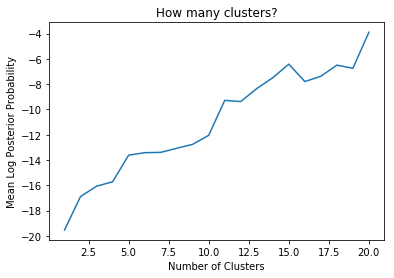

In [142]:
import matplotlib.pyplot as plt

plt.plot(np.arange(1, MAX_CLUSTERS + 1), scores)
plt.xlabel('Number of Clusters')
plt.ylabel('Mean Log Posterior Probability')
plt.title('How many clusters?')
plt.show()